<a href="https://colab.research.google.com/github/TiagoBruno00/Redes_Neuronales/blob/C%C3%B3digo/1_Autoencoder_lineal_512.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import sklearn as skl
import pandas as pd
# from torchviz import make_dot
import torch.optim as optim
#from collections import defaultdict
#import pickle
from torch.utils.data import random_split
import pickle
import random
# import dill
import json
import datetime
try:
    import google.colab
    from google.colab import files
    COLAB = True
except:
    COLAB = False

In [ ]:
# Chequeamos que este el GPU o el CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Usando el dispositivo {}'.format(device))

Usando el dispositivo cuda


In [ ]:
# 1. Descargar y preparar los datos
train_dataset = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
valid_dataset = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

# DataLoader
batch_size = 1000
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 26421880/26421880 [00:01<00:00, 14549459.13it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 264258.67it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4869054.37it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19718974.42it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
# 2. Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, hidden_size=512, dropout_rate=0.1):
        super().__init__()
        self.encoder = nn.Linear(28*28, hidden_size)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.decoder = nn.Linear(hidden_size, 28*28)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(x.size(0), -1) # vector 1x784
        x = torch.relu(self.encoder(x))
        x = self.dropout(x)
        x = self.sigmoid(self.decoder(x))
        return x

In [ ]:
# 3. Modelo
autoencoder = Autoencoder(hidden_size=512, dropout_rate=0.1)
autoencoder.to(device)
criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

In [ ]:
# 4. Entrenamiento y Validación
def train(loader, model, optimizer, criterion):
    model.train()
    train_loss = 0.0
    for data in loader:
        inputs, _ = data
        inputs = inputs.to(device)  # Mover los datos al dispositivo adecuado
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs.view(inputs.size(0), -1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(loader)

def validate(loader, model, criterion):
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for data in loader:
            inputs, _ = data
            inputs = inputs.to(device)  # Mover los datos al dispositivo adecuado
            outputs = model(inputs)
            loss = criterion(outputs, inputs.view(inputs.size(0), -1))
            valid_loss += loss.item()
    return valid_loss / len(loader)

# Uso de las funciones de entrenamiento y validación
num_epochs = 60
train_losses_incorrecto = []  # Error de entrenamiento sin modo evaluación
train_losses = []  # Error de entrenamiento con modo evaluación
test_losses = []

for epoch in range(num_epochs):
    train_loss_incorrecto = train(train_loader, autoencoder, optimizer, criterion)
    train_loss = validate(train_loader, autoencoder, criterion)  # Error de entrenamiento con modo evaluación
    test_loss = validate(valid_loader, autoencoder, criterion)
    train_losses_incorrecto.append(train_loss_incorrecto)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    # Imprimir progreso
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {test_loss:.4f}')

Epoch [1/60], Train Loss: 0.0361, Valid Loss: 0.0359
Epoch [2/60], Train Loss: 0.0239, Valid Loss: 0.0240
Epoch [3/60], Train Loss: 0.0189, Valid Loss: 0.0191
Epoch [4/60], Train Loss: 0.0155, Valid Loss: 0.0157
Epoch [5/60], Train Loss: 0.0134, Valid Loss: 0.0136
Epoch [6/60], Train Loss: 0.0119, Valid Loss: 0.0121
Epoch [7/60], Train Loss: 0.0112, Valid Loss: 0.0113
Epoch [8/60], Train Loss: 0.0101, Valid Loss: 0.0102
Epoch [9/60], Train Loss: 0.0094, Valid Loss: 0.0095
Epoch [10/60], Train Loss: 0.0091, Valid Loss: 0.0092
Epoch [11/60], Train Loss: 0.0085, Valid Loss: 0.0086
Epoch [12/60], Train Loss: 0.0082, Valid Loss: 0.0083
Epoch [13/60], Train Loss: 0.0078, Valid Loss: 0.0079
Epoch [14/60], Train Loss: 0.0074, Valid Loss: 0.0076
Epoch [15/60], Train Loss: 0.0075, Valid Loss: 0.0076
Epoch [16/60], Train Loss: 0.0069, Valid Loss: 0.0071
Epoch [17/60], Train Loss: 0.0067, Valid Loss: 0.0068
Epoch [18/60], Train Loss: 0.0066, Valid Loss: 0.0067
Epoch [19/60], Train Loss: 0.0063, Va

In [ ]:
# Guardar pesos del autoencoder y MSE
torch.save(autoencoder.state_dict(), 'pesos_autoencoder_lineal.pth')
torch.save(train_losses, 'mse_train_lineal.pth')
torch.save(test_losses, 'mse_test_lineal.pth')

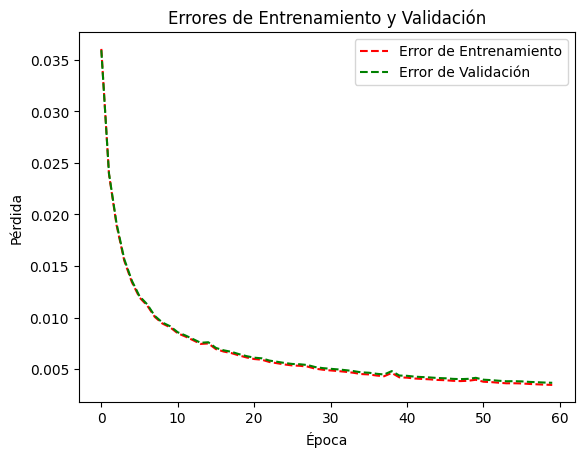

In [ ]:
# 5. Gráfico de errores de entrenamiento y validación
plt.plot(train_losses, label='Error de Entrenamiento', color='red', linestyle='--')
plt.plot(test_losses, label='Error de Validación', color='green', linestyle='--')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Errores de Entrenamiento y Validación')
plt.legend()
plt.show()

In [ ]:
# 6. Decisión sobre el número de épocas

def determinar_numero_epocas_error(error_set, patience=10, min_delta=0.0001):
    best_error = error_set[0]
    epochs_without_improvement = 0
    for i, error in enumerate(error_set):
        if error < best_error - min_delta:
            best_error = error
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                return i - patience
    return len(error_set)  # Si no converge en el conjunto, se devuelve el número total de épocas

z, w, y = [determinar_numero_epocas_error(train_losses_incorrecto), determinar_numero_epocas_error(test_losses), determinar_numero_epocas_error(train_losses)]
print(f"Época según error durante el entrenamiento: {z}")
print(f"Época según error de validación: {w}")
print(f"Época según error de entrenamiento: {y}")


Época según error durante el entrenamiento: 60
Época según error de validación: 60
Época según error de entrenamiento: 60


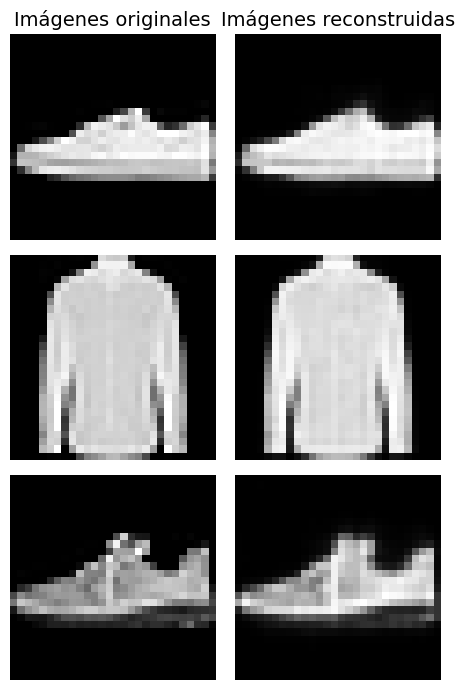

In [ ]:
# 7. Imágenes origninales vs predichas

# Crear semilla para obtener un índice aleatorio y reproducible
seed = 6
torch.manual_seed(seed)
random.seed(seed)

# Obtener la lista de índices del conjunto de validación
indices_val = list(range(len(valid_dataset)))

# Seleccionar tres índices de muestra aleatorios y fijarlos
sample_idx1, sample_idx2, sample_idx3 = random.sample(indices_val, 3)

# Obtener las nuevas imágenes y sus etiquetas del conjunto de validación
imagen1, label1 = valid_dataset[sample_idx1]
imagen2, label2 = valid_dataset[sample_idx2]
imagen3, label3 = valid_dataset[sample_idx3]

# Obtener las predicciones del modelo
with torch.no_grad():
    # Imagen 1
    imagen1_gpu = imagen1.to(device)
    imagen1_flatten = imagen1_gpu.unsqueeze(0).to(device)
    pred1_gpu = autoencoder(imagen1_flatten)
    pred1_cpu = pred1_gpu.cpu().view(1, 28, 28).squeeze().numpy()

    # Imagen 2
    imagen2_gpu = imagen2.to(device)
    imagen2_flatten = imagen2_gpu.unsqueeze(0).to(device)
    pred2_gpu = autoencoder(imagen2_flatten)
    pred2_cpu = pred2_gpu.cpu().view(1, 28, 28).squeeze().numpy()

    # Imagen 3
    imagen3_gpu = imagen3.to(device)
    imagen3_flatten = imagen3_gpu.unsqueeze(0).to(device)
    pred3_gpu = autoencoder(imagen3_flatten)
    pred3_cpu = pred3_gpu.cpu().view(1, 28, 28).squeeze().numpy()

# Crear una nueva figura con 3 filas y 2 columnas
fig, axes = plt.subplots(3, 2)
fig.set_size_inches(5, 7)

# Títulos de las filas
axes[0, 0].set_title('Imágenes originales', fontsize=14)
axes[0, 1].set_title('Imágenes reconstruidas', fontsize=14)

# Imagen original 1
axes[0, 0].imshow(imagen1.squeeze(), cmap="gray")
axes[0, 0].axis("off")

# Reconstrucción del autoencoder 1
axes[0, 1].imshow(pred1_cpu, cmap="gray")
axes[0, 1].axis("off")

# Imagen original 2
axes[1, 0].imshow(imagen2.squeeze(), cmap="gray")
axes[1, 0].axis("off")

# Reconstrucción del autoencoder 2
axes[1, 1].imshow(pred2_cpu, cmap="gray")
axes[1, 1].axis("off")

# Imagen original 3
axes[2, 0].imshow(imagen3.squeeze(), cmap="gray")
axes[2, 0].axis("off")

# Reconstrucción del autoencoder 3
axes[2, 1].imshow(pred3_cpu, cmap="gray")
axes[2, 1].axis("off")

# Ajustar el espacio horizontal entre las columnas
plt.subplots_adjust(wspace=0.01)

# Ajuste del diseño y mostrar la figura
fig.tight_layout()
plt.show()
